In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Various techniques for the improvement of an image classifier will be tested.
We will use a data set of low resolution handwritten digits

In [0]:
from sklearn.datasets import load_digits

In [0]:
ld = load_digits()

In [0]:
X, y = ld.data,ld.target

In [0]:
X.shape

(1797, 64)

In [0]:
y.shape

(1797,)

In [0]:
y[59]

3

The data set contains 1797 low resolution 8*8 images of digits with corresponding labels.

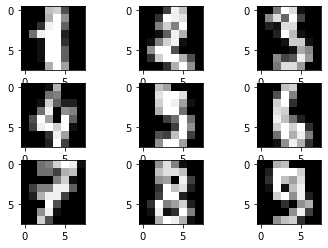

In [0]:
# let's visualize some of the digits
for i in range(1,10):
  plt.subplot(3,3,i)
  plt.imshow(X.reshape(-1,8,8)[i],cmap = 'gray')

#### Choosing an optimal train-test split 

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [0]:
# Fully connected predictor
K.clear_session()

model = Sequential()

model.add(Dense(16,input_shape =(64,),activation = 'relu'))
model.add(Dense(10,activation ='softmax'))

model.compile(loss='categorical_crossentropy',metrics =['accuracy'],optimizer = 'rmsprop')

In [0]:
# we will be trying different values of train sets, so we need to fix the initial weights
# for the 'purity' of the experiment

initial_weights = model.get_weights()

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# convert numbers in the label column to binary class vectors
y_cat = to_categorical(y,10)

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y_cat,test_size = 0.3)

In [0]:
train_sizes = (len(X_train)*np.linspace(0.1,0.99,8)).astype('int')

In [0]:
train_sizes

array([ 125,  285,  445,  605,  764,  924, 1084, 1244])

In [ ]:
train_scores = []
test_scores = []

for i in train_sizes:
  
  
  X_train_frac,_, y_train_frac, _ = \
  train_test_split(X_train,y_train,train_size= i)
  
  # at each iteration reset the weights of the model
  # to the initial random weights
  model.set_weights(initial_weights)
  h = model.fit(X_train_frac,y_train_frac,epochs = 300,callbacks =[EarlyStopping(monitor ='loss',patience = 2)])
  r = model.evaluate(X_train_frac,y_train_frac)
  train_scores.append(r[-1])
  
  e = model.evaluate(X_test,y_test)
  test_scores.append(e[-1])
  
  print('Done: ',i)

In [0]:
train_scores

[1.0,
 1.0,
 1.0,
 0.9983471035957336,
 1.0,
 0.9989177584648132,
 0.9990774989128113,
 1.0]

In [0]:
test_scores

[0.8518518805503845,
 0.914814829826355,
 0.9425926208496094,
 0.9537037014961243,
 0.9555555582046509,
 0.9648148417472839,
 0.9759259223937988,
 0.9759259223937988]

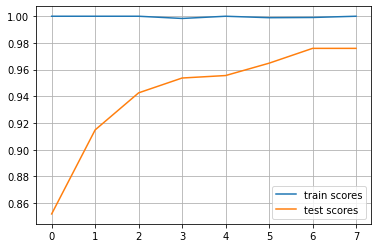

In [0]:
plt.plot(train_scores)
plt.plot(test_scores)
plt.grid()
plt.legend(['train scores','test scores'],loc = 'best')


In [2]:
# hence the last two data splits (i.e. training sizes of 1084 and 1244) give the best accuracy.

#### Batch normalization 
- an efficient technique for improving the performance and stability of an artificial NN

In [0]:
from keras.layers import BatchNormalization

In [0]:
# define a function that will take a boolean variable do_bn ('do batch normalization') as an argument
def repeated_training(X_train,y_train,X_test,y_test,units = 512,do_bn = False,
                      activation = 'sigmoid',optimizer = 'sgd',epochs = 10,repeats = 3):
    
    '''This function defines a fully connected NN model with optional batch normalization.
    The function returns the model accuracy and validation accuracy across three repeats.'''
  
  histories = []
  
  for repeat in range(repeats):
    
    K.clear_session()
  
    model = Sequential()
  
    model.add(Dense(units,input_shape = (X_train.shape[1:]),kernel_initializer ='normal',activation = activation))
  
    if do_bn:
      model.add(BatchNormalization())
    
    model.add(Dense(units,kernel_initializer = 'normal',activation = activation))
  
    if do_bn:
      model.add(BatchNormalization())
    
    model.add(Dense(units,kernel_initializer = 'normal',activation = activation))
  
    if do_bn:
      model.add(BatchNormalization())
  
    model.add(Dense(10,activation='softmax'))
  
    model.compile(loss = 'categorical_crossentropy',metrics=['accuracy'],optimizer = optimizer)
  
    h = model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = epochs)
    
    histories.append([h.history['accuracy'],h.history['val_accuracy']])
    
    print('repeat = ',repeat)
    
  histories = np.array(histories)
    
  #calculate mean and standard deviations across repeats
  
  mean_acc = histories.mean(axis=0)
  std_acc = histories.std(axis=0)
  
  return mean_acc[0],std_acc[0],mean_acc[1],std_acc[1]



In [0]:
# the case without batch normalization
mean_acc,std_acc,mean_val_acc,std_val_acc = repeated_training(X_train,y_train,X_test,y_test)

In [0]:
mean_acc

array([0.0997083 , 0.13259082, 0.13709891, 0.1516839 , 0.17740652,
       0.1922567 , 0.21904004, 0.23256431, 0.30654999, 0.32617343])

In [0]:
std_acc

array([0.01109968, 0.00892997, 0.00603543, 0.0085189 , 0.01277834,
       0.03428748, 0.0412577 , 0.03271314, 0.01576437, 0.0084526 ])

In [0]:
# the case with batch normalization after each layer
mean_acc_bn,std_acc_bn,mean_val_acc_bn,std_val_acc_bn = repeated_training(X_train,y_train,X_test,y_test,do_bn=True)

In [0]:
def plot_mean_std(m,s):
  
  plt.plot(m)
  
  plt.fill_between(range(len(m)),m+s,m-s,alpha =0.1)
  plt.grid()

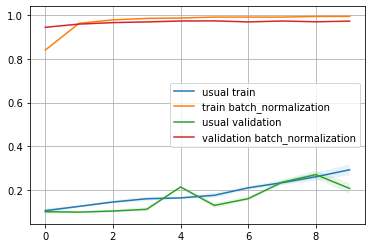

In [0]:
plot_mean_std(mean_acc,std_acc)
plot_mean_std(mean_acc_bn,std_acc_bn)
plot_mean_std(mean_val_acc,std_acc)
plot_mean_std(mean_val_acc_bn,std_acc_bn)
plt.grid()
plt.legend(['usual train','train batch_normalization','usual validation','validation batch_normalization'])

In [0]:
# clearly, in this case batch normalization drastically improves the accuracy as well as the stability of the model

#### Dropout 
 - an efficient regularization technique aimed at reducing overfitting

In [0]:
from keras.layers import Dropout

In [0]:
digits = load_digits()
X, y = digits.data, digits.target
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)

In [0]:
def repeated_training_reg_dropout(X_train,
                                  y_train,
                                  X_test,
                                  y_test,
                                  units=512,
                                  activation='sigmoid',
                                  optimizer='sgd',
                                  do_dropout=False,
                                  rate=0.3,
                                  kernel_regularizer='l2',
                                  epochs=700,
                                  repeats=3):
    '''This function defines a fully connected NN model with optional dropout regularization.
    The function returns the model accuracy and validation accuracy across three repeats.'''
    
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()

               
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0)
        #print('history keys',h.history.keys())
        histories.append([h.history['accuracy'], h.history['val_accuracy']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [0]:
mean_acc, std_acc, mean_acc_val, std_acc_val = repeated_training_reg_dropout(X_train,
                                                                             y_train,
                                                                             X_test,
                                                                             y_test,
                                                                             do_dropout=False)

0 1 2 


In [0]:
mean_acc_do, std_acc_do, mean_acc_val_do, std_acc_val_do = repeated_training_reg_dropout(X_train,
                                                                                         y_train,
                                                                                         X_test,
                                                                                         y_test,
                                                                                         do_dropout=True)

0 1 2 


In [0]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

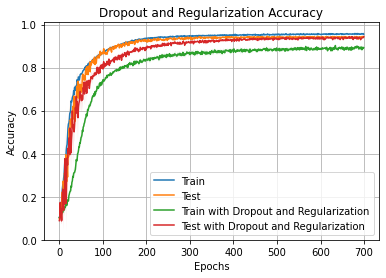

In [0]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_do, std_acc_do)
plot_mean_std(mean_acc_val_do, std_acc_val_do)
plt.ylim(0, 1.01)
plt.title("Dropout and Regularization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test','Train with Dropout and Regularization','Test with Dropout and Regularization'], loc='best')
plt.grid()

In [0]:
# dropout and regularization make the model less prone to overfitting, although more prone to underfitting

#### Data augmentation. Case in point: images

Depending on the situation, the performance of a machine learning model can be improved either by improving the actual model or by feeding more data to the model. In the latter case, there can be physical limitations as to the amount of data that can be collected. In a situation like this, there is a workaround by generating artificially new data off the existing data. The technique can be applied to images (an existing image can be twisted, flipped, zoomed, rotated, darkened, etc.), sound, and even text. Below we illustrate the implementation of this principle on an image using Keras.  

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
# Generate image data with real-time data augmentation (pass transforming operations as arguments)
generator = ImageDataGenerator(rescale = 1./255,
                              width_shift_range = 0.1,
                              height_shift_range=0.1,
                              rotation_range=20,
                              shear_range = 0.3,
                              zoom_range=0.3,
                              horizontal_flip = True)

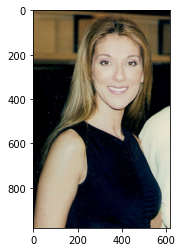

In [60]:
# As an example, we will be augmenting a picture of Celine Dion by Linda Bisset
import matplotlib.image as mpimg
img=mpimg.imread('/CelineDion/Celine_Dion_by_Linda_Bisset.jpg')
imgplot = plt.imshow(img)


In [ ]:
# generate batches of augmented data
train = generator.flow_from_directory('/CelineDion/',
                                     target_size=(981,616),
                                     class_mode = 'categorical'
                                     )

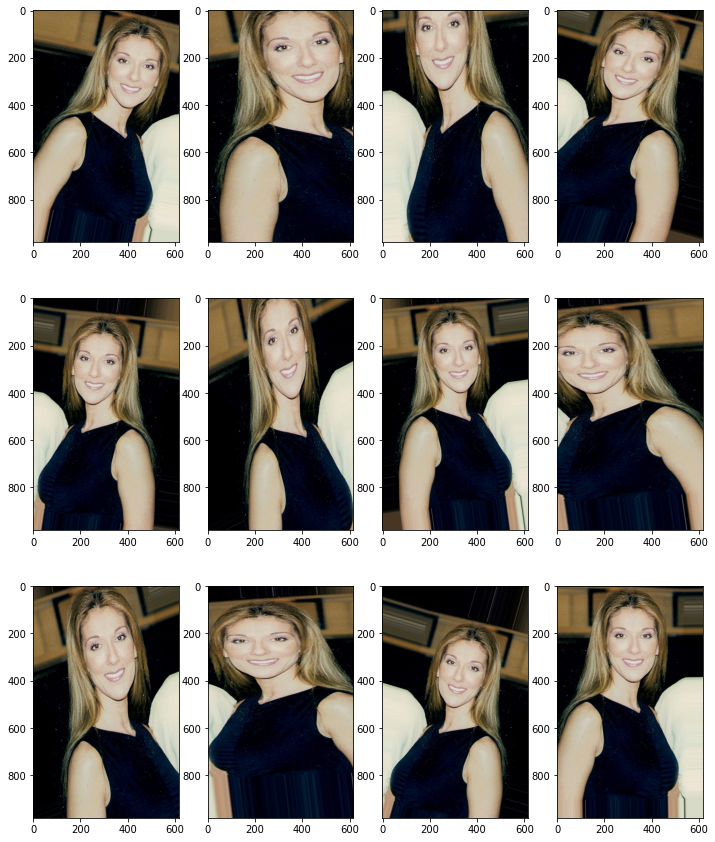

In [69]:
# display the data generated
plt.figure(figsize=(12,15))
for i in range(12):
  img,label = train.next()
  plt.subplot(3,4,i+1)
  plt.imshow(img[0])

In [0]:
# This is how we make 12 new images out of one.  